In [43]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
import math


In [44]:
# Helper Function which overwrites any incompatible library import from collab
def cv2_imshow(imgz, title=None):
    plt.imshow(imgz)
    if title is not None:
        plt.title(title)
    plt.show()


im shape: (540, 960)
im dim: 2


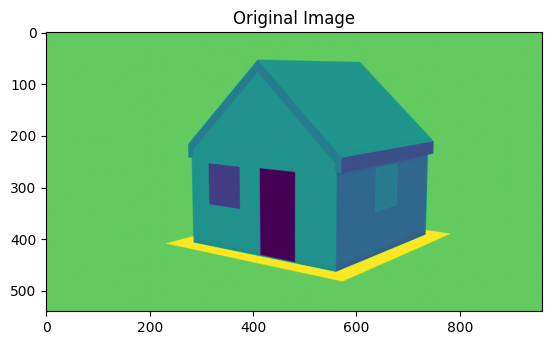

In [45]:
image = cv2.imread("house1.png", 0)

print("im shape:", image.shape)
print("im dim:", image.ndim)
cv2_imshow(image, "Original Image")


Gauss Filter

In [46]:
# Gaussian
def gaussian_filter(_A, a=1, sigma=1):
    A = np.copy(_A)
    M, N = A.shape
    a = a
    b = a
    m = 2*a+1
    n = 2*b+1

    # Kernel Creation
    sigma = sigma
    g = np.zeros((m, m))
    for s in range(-a, a+1):
        for t in range(-b, b+1):
            r2 = s*s + t*t  # distance squared from center of kernel
            # Formula corrected from r2/2/(sigma*sigma))
            g[s+a, t+b] = math.exp(-r2/(2*(sigma**2)))

    w = g/np.sum(g)  # Gauss Kernel Array
    #cv2_imshow(w, 'Gauss Kernel')

    # Kernel Application
    B = np.copy(A)
    for i in range(a, M-a):
        for j in range(b, N-b):
            I = 0
            for s in range(-a, a+1):
                for t in range(-b, b+1):
                    I = I + w[s+a, t+b] * A[i+s, j+t]
            B[i, j] = round(I)

    #cv2_imshow(B, 'Gauss Blurred Image')
    return B


Execution

Sobel Filter

In [48]:
# Sobel Application
def apply_sobel(img):

    # Sobel Kernels
    sobel_x = np.array([[1, 2, 1],
                        [0, 0, 0],
                        [-1, -2, -1]])
    sobel_y = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]])

    fill_val = img[0][0]

    # Application of the kernels
    Gx = convolve2d(img, sobel_x ,fillvalue=fill_val)
    Gy = convolve2d(img, sobel_y,fillvalue=fill_val)

    # Magnitude
    Gs = np.sqrt(Gx**2 + Gy**2)
    # Direction
    theta = np.arctan2(Gy, Gx)

    return Gx, Gy, Gs, theta


Non-Maxima Suppression

In [80]:
# Non-maxima suppression
def non_max_suppression(G_theta, _G_mag):
    G_mag = np.copy(_G_mag) # Create empty image
    #deg_trans = lambda t: t * 180 / np.pi
    #vect = np.vectorize(deg_trans)

    # Transform theta into degrees
    G_deg = G_theta * (180 / np.pi)

    for i in range(1, G_deg.shape[0]-1):
        for j in range(1, G_deg.shape[1]-1):

            elem_g = G_mag[i][j]        # Magnitude intensity
            current_theta = G_deg[i][j] # Direction

            # Orthogonal Direction
            #alpha = current_theta - 90 if current_theta - 90 >= -180 else current_theta + 90
            alpha = current_theta
            # Horizontal
            #maybe reformat this way np.isclose(0, elem, atol= 22.5)
            if -22.5 < alpha <= 22.5 or -180 < alpha <= -157.5 or 157.5 < alpha <= 180:
                elem1_hor = G_mag[i-1][j]
                elem2_hor = G_mag[i+1][j]
                local_maxima = max(elem_g, elem1_hor, elem2_hor)

            # Vertical
            elif 67.5 < alpha <= 112.5 or -112.5 < alpha <= -67.5:
                elem1_hor = G_mag[i][j+1]
                elem2_hor = G_mag[i][j-1]
                local_maxima = max(elem_g, elem1_hor, elem2_hor)

            # Diagonal 45
            elif 112.5 < alpha <= 157.5 or -67.5 < alpha <= -22.5:
                elem1_hor = G_mag[i+1][j+1]
                elem2_hor = G_mag[i-1][j-1]
                local_maxima = max(elem_g, elem1_hor, elem2_hor)

            # Diagonal -45
            elif 22.5 < alpha <= 67.5 or -157.5 < alpha <= -112.5:
                elem1_hor = G_mag[i-1][j+1]
                elem2_hor = G_mag[i+1][j-1]
                local_maxima = max(elem_g, elem1_hor, elem2_hor)

            if elem_g != local_maxima:
                G_mag[i][j] = 0

    return G_mag

Execution

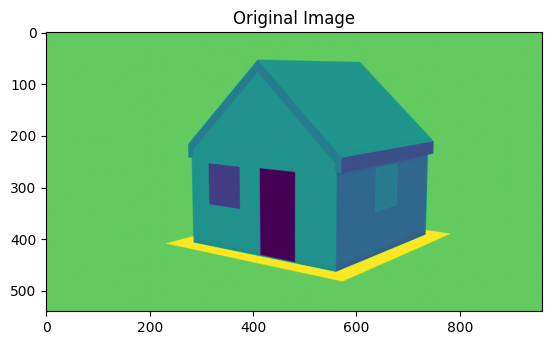

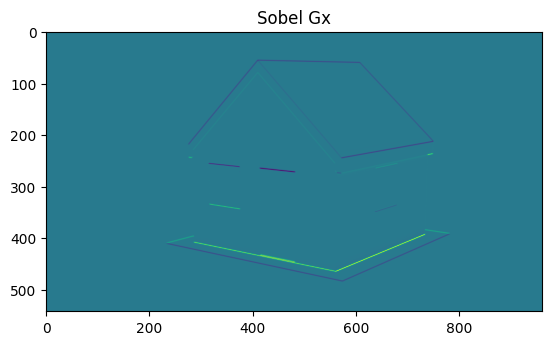

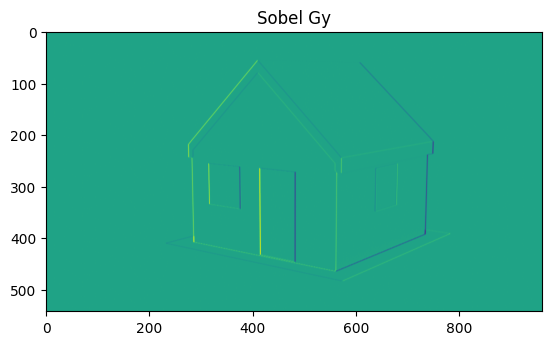

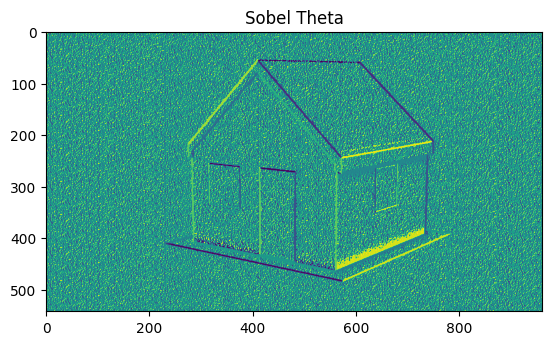

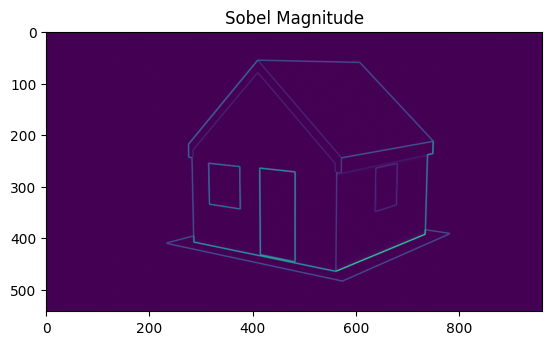

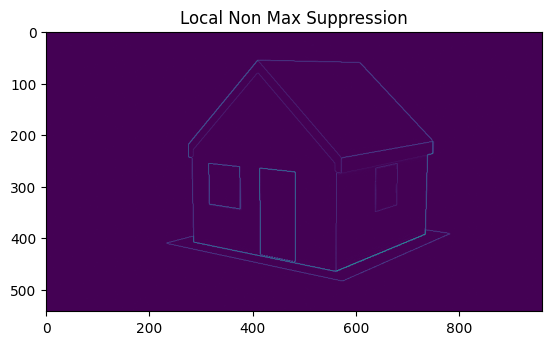

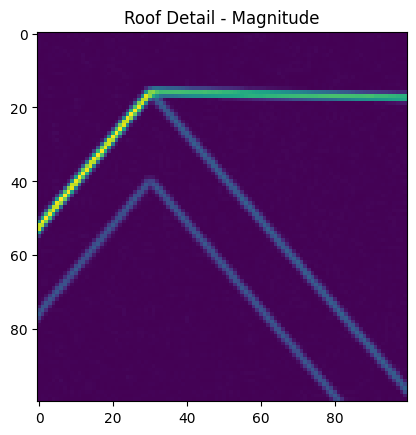

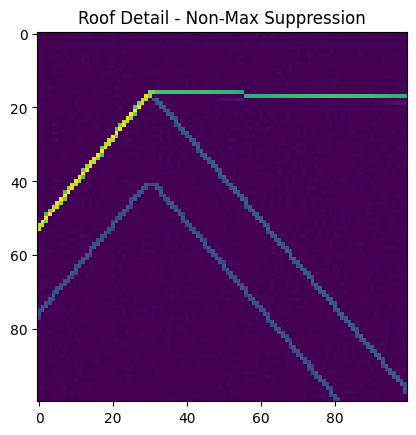

In [81]:
Gx,Gy,Gs,G_theta = apply_sobel(image)
cv2_imshow(image, "Original Image")
cv2_imshow(Gx, 'Sobel Gx')
cv2_imshow(Gy, 'Sobel Gy')
cv2_imshow(G_theta, 'Sobel Theta')
cv2_imshow(Gs, 'Sobel Magnitude')

#Non Maxima Suppression
G_prime = non_max_suppression(G_theta, Gs)
cv2_imshow(G_prime, "Local Non Max Suppression")

# Detail Comparison
cv2_imshow(Gs[40:140,380:480], 'Roof Detail - Magnitude')
cv2_imshow(G_prime[40:140,380:480], "Roof Detail - Non-Max Suppression")

Double Threshold

In [82]:
def double_threshold(img, min, max):
    A = np.copy(img)
    M, N = A.shape
    for i in range(M):
        for j in range(N):
            if A[i, j] >= max:
                A[i, j] = max
            elif min <= A[i, j] < max:
                A[i, j] = min
            else:
                A[i, j] = 0
    return A

In [83]:
# Used to decide on min and max values for double Threshold
def plot_histogram(img, name):
    A = np.copy(img)
    A_vals = A.flatten()
    A_unique = set(A_vals)
    print(name, "total unique values:", len(A_unique))

    plt.hist(x=list(A_vals), histtype='stepfilled')
    plt.yscale('log')
    plt.show()

Execution

G_prime total unique values: 2641


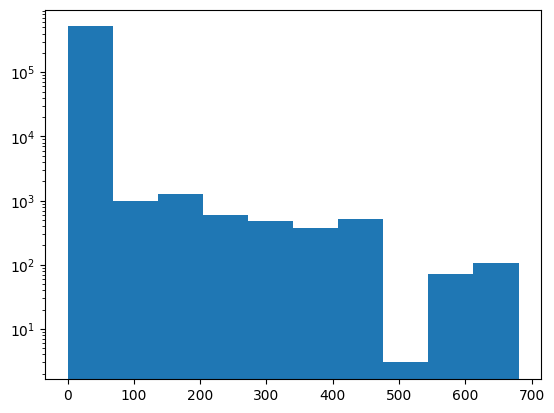

Threshold Image total unique values: 3


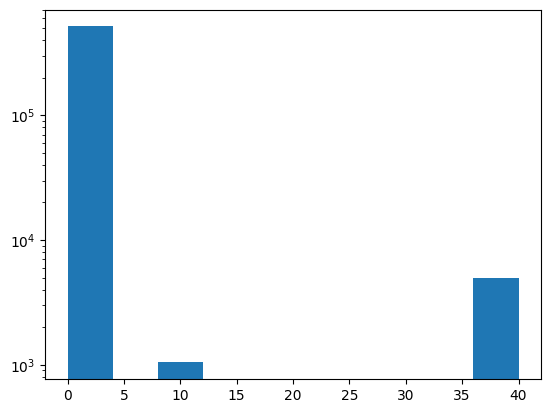

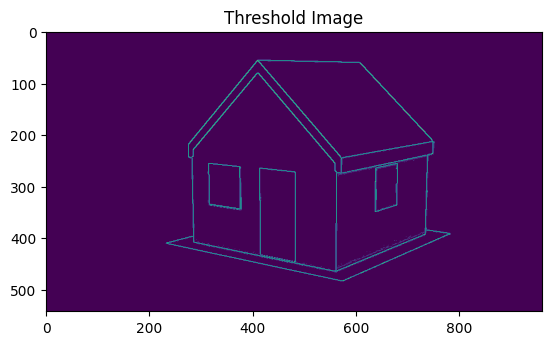

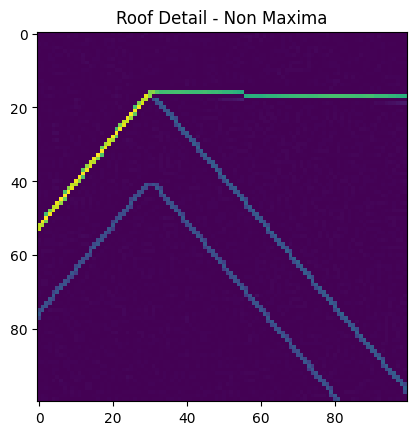

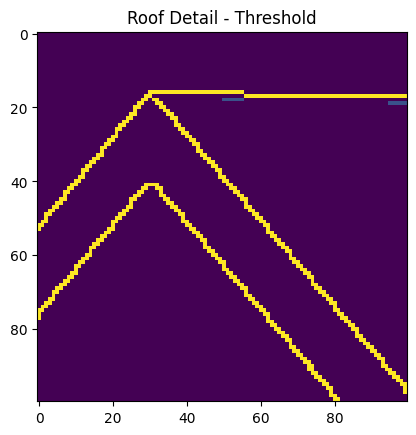

In [84]:
G_thresh = double_threshold(G_prime, 10, 40)

plot_histogram(G_prime, "G_prime")
plot_histogram(G_thresh, "Threshold Image")
cv2_imshow(G_thresh, "Threshold Image")

# Detail Comparison
cv2_imshow(G_prime[40:140,380:480], 'Roof Detail - Non Maxima')
cv2_imshow(G_thresh[40:140,380:480], "Roof Detail - Threshold")


Connectivity Functions

In [85]:
def connectivity(x, y):
    neighbors = []

    neighbors.append((x+1, y))
    neighbors.append((x-1, y))
    neighbors.append((x, y+1))
    neighbors.append((x, y-1))
    neighbors.append((x+1, y+1))
    neighbors.append((x-1, y-1))
    neighbors.append((x-1, y+1))
    neighbors.append((x+1, y-1))

    return neighbors


def get_edges(img):

    width = len(img)
    height = len(img[0])
    edges = img >= 40
    #print("SHAPE OF IMAGES ", img.shape)
    #print("SHAPE OF EDGES IS", edges.shape)
    #print("len OF EDGES 0 IS", len(edges))
    #print("len OF EDGES 1 IS", len(edges[1]))
    queue = []

    for i in range(1, len(edges)-1):
        for j in range(1, len(edges[1])-1):
            if edges[i][j] == True:
                queue.append((i, j))

    while len(queue) > 0:
        elem = queue.pop()
        to_add = connectivity(elem[0], elem[1])
        for cand in to_add:
            # print("CAND IS", cand)

            if (cand[0] < width-1 and cand[1] < height - 1):
                if edges[cand[0], cand[1]] == True:
                    continue

                intensity = img[cand[0], cand[1]]
                if intensity >= 5 and intensity < 100:
                    queue.append((cand[0], cand[1]))
                    # print("ADDED")

        edges[elem[0], elem[1]] = True

    return edges


Execution

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


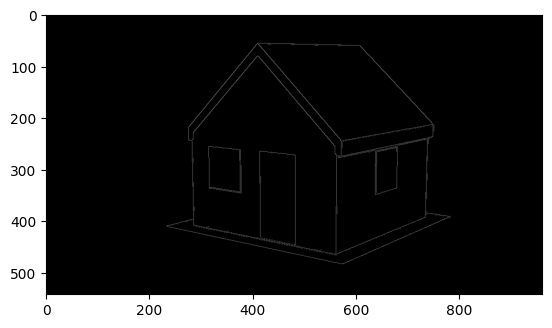

In [86]:
connected_img = get_edges(G_thresh)
binary_image = np.where(connected_img == True, 100, 0)

print(binary_image)

# plt.clf()
plt.imshow(binary_image, cmap='gray', vmin=0, vmax=255)
plt.show()

# a colormap and a normalization instance
cmap = plt.cm.jet
norm = plt.Normalize(vmin=binary_image.min(), vmax=binary_image.max())
image = cmap(norm(binary_image))
img = plt.imsave('canny_result.png', binary_image, cmap='gray')


Canny Filter

In [95]:
def canny_filter(img):
    G = np.copy(img)
    #G_gauss = gaussian_filter(G, a=1, sigma=1) # Not used
    Gx, Gy, Gs, Gt = apply_sobel(G)  # Gx,Gy, Magnitude, Theta
    G_nms = non_max_suppression(G_theta=Gt, _G_mag=Gs)
    G_threshold = double_threshold(G_nms, 40, 100)
    G_edges = get_edges(G_threshold)
    G_binary = np.where(G_edges == True, 100, 0)
    return G_binary


Execution

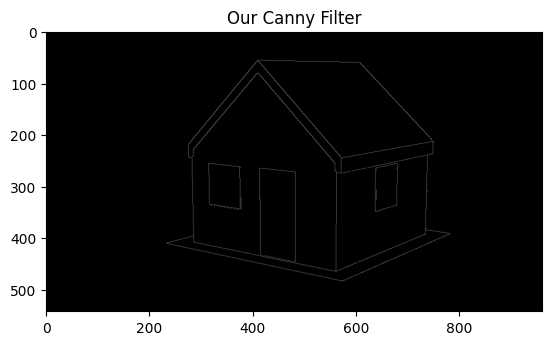

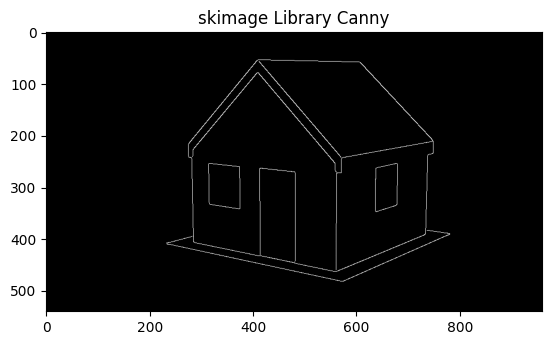

In [96]:
# Our implementation
image = cv2.imread("house1.png", 0)
our_image = canny_filter(image)
plt.imshow(our_image, cmap='gray', vmin=0, vmax=255)
img = plt.imsave('canny_result.png', our_image, cmap='gray')
plt.title("Our Canny Filter")
plt.show()

# Vs Library
from skimage.feature import canny
plt.imshow(canny(np.copy(image)), cmap='gray')
plt.title("skimage Library Canny")
plt.show()
